In [ ]:
!git clone https://github.com/ViktorAnchutin/detecting_active_emotion.git;
!mv detecting_active_emotion/* .

In [ ]:
!pip install transformers --quiet;
!pip install timm --quiet;

In [1]:
import pandas as pd
from itertools import chain
from torch import nn
from data.utils import *
from transformers import Wav2Vec2Model
from experiments.models import W2V2Model, ConvNextModel
from data.dataloader import create_dataloader, MultiDataLoader
from framework.learning_rate import ExponentialLRCalculator,CosineLRCalculator
from experiments.experiment_runner import Training, TrainingConfig
from matplotlib import pyplot as plt
import torchaudio
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
w2v_features_path = 'D:/FYP/w2v_features'

# Check that there is an audio backend
if len(torchaudio.list_audio_backends()) <= 0:
    raise RuntimeError("No audio backend detected!")

print(f"Audio backend : {torchaudio.list_audio_backends()[0]}")
print(f"Torch version : {torch.__version__}")
print(f"Device : {device}")
print(f"Torchaudio version : {torchaudio.__version__}")
print(f"Is CUDA available : {torch.cuda.is_available()}")
print(f"CUDA Version : {torch.cuda_version}")
print(f"CUDA Device : {torch.cuda.current_device()}")

Audio backend : soundfile
Torch version : 2.0.1+cu118
Device : cuda
Torchaudio version : 2.0.2+cu118
Is CUDA available : True
CUDA Version : 11.8
CUDA Device : 0


# Annotations preprocessing

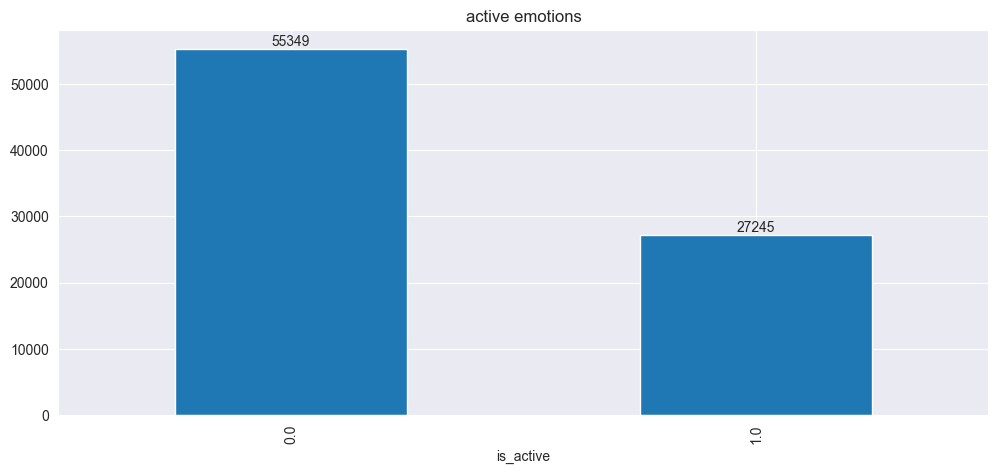

In [2]:
data = pd.read_csv("labels_consensus.csv").set_index("FileName")
data = data[data.SpkrID != 'Unknown']
data['is_active'] = data.apply(lambda x: 1. if x['EmoAct'] >= 5 else 0.,axis=1)

def plot_label(data,label,ax=None,title=None):
  barc = data[label].value_counts().plot.bar(ax=ax,title=title)
  barc.bar_label(barc.containers[0], label_type='edge')

_,ax = plt.subplots(1,figsize=(12, 5));
plot_label(data, 'is_active',ax=ax, title='active emotions');

C:\Users\Nazrin\AppData\Local\Temp\ipykernel_21292\2078040302.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_counts = data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)}))


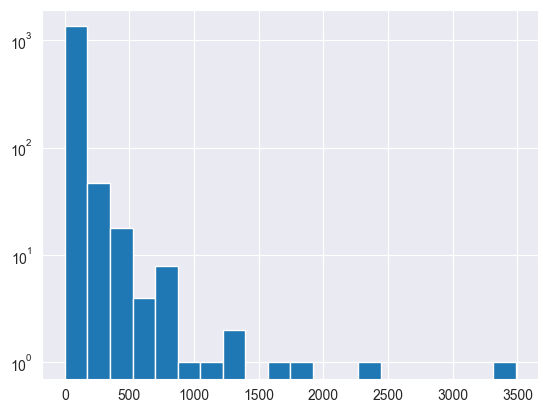

In [3]:
speaker_counts = data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)}))
speaker_counts.cnt.hist(log=True,bins=20);

C:\Users\Nazrin\AppData\Local\Temp\ipykernel_21292\3307446617.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)})).hist();


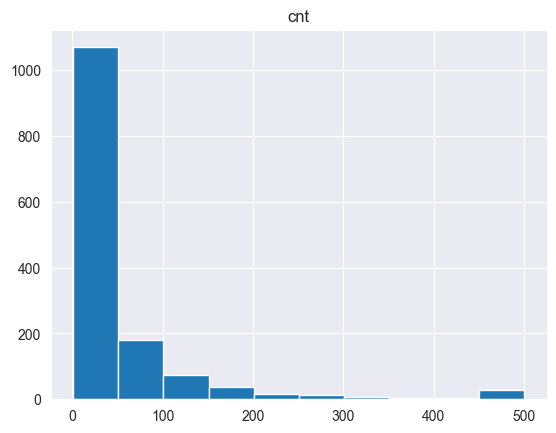

In [4]:
def downsample_speaker(data,speaker,limit=500):
  sampled_ids = data[data['SpkrID'] == speaker].sample(limit).index
  todrop = data[(data['SpkrID'] == speaker)&(~data.index.isin(sampled_ids))].index
  return data.drop(todrop)

for sid in speaker_counts[speaker_counts.cnt >= 500].index:
  data = downsample_speaker(data,sid)

data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)})).hist();

55710
14129


C:\Users\Nazrin\AppData\Local\Temp\ipykernel_21292\354010679.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('custom_partition').apply(lambda x: pd.Series({'unique speakers':len(x.SpkrID.unique())}))


,unique speakers
custom_partition,
Test,286
Train,1146


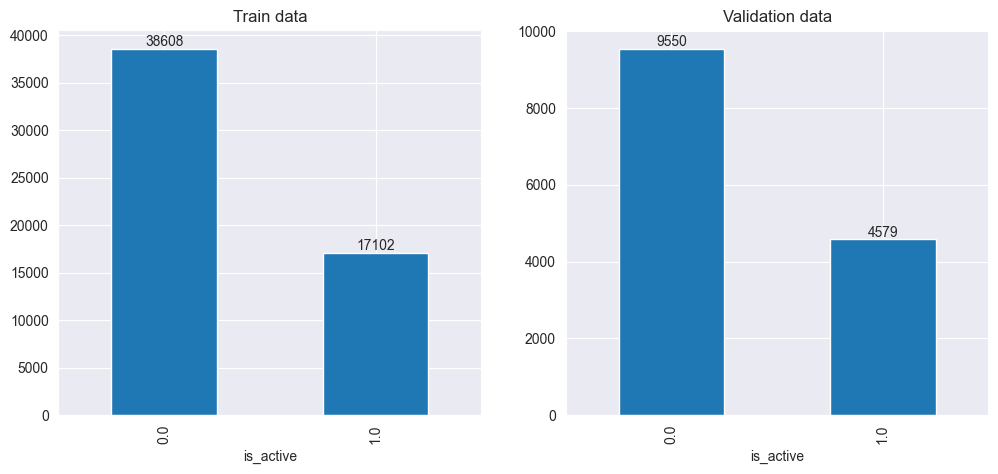

In [5]:
speakers = data.SpkrID.value_counts()

holdout_speakers = speakers.sample(round(len(speakers)*0.2), random_state=123)
data.loc[:,'custom_partition'] = data.apply(lambda x: 'Test' if x['SpkrID'] in holdout_speakers.index else 'Train', axis=1)

train_data = data[data.custom_partition == 'Train']
valid_data = data[data.custom_partition == 'Test']

print(len(train_data))
print(len(valid_data))

_,ax = plt.subplots(1,2,figsize=(12, 5));
plot_label(train_data, 'is_active', ax=ax[0], title='Train data');
plot_label(valid_data, 'is_active', ax=ax[1], title='Validation data');

data.groupby('custom_partition').apply(lambda x: pd.Series({'unique speakers':len(x.SpkrID.unique())}))

## Collect information about duration

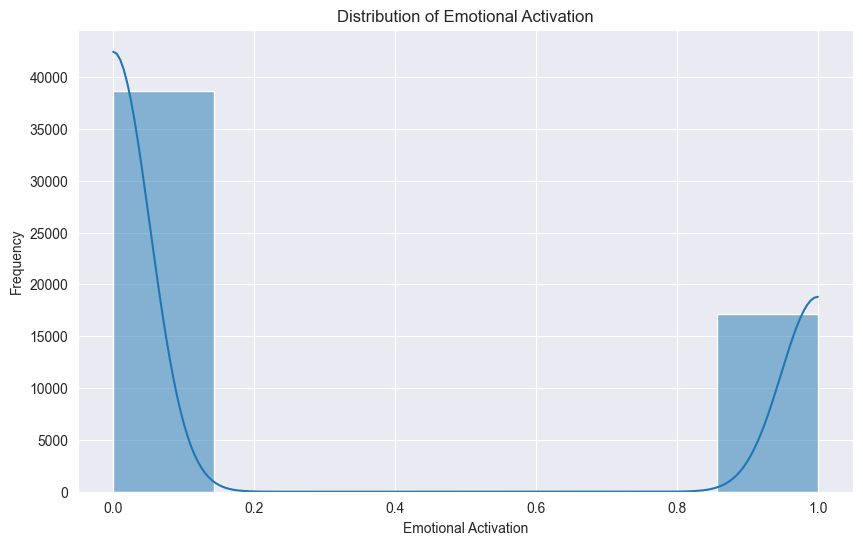

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_data['is_active'], kde=True, bins=7)
plt.title('Distribution of Emotional Activation')
plt.xlabel('Emotional Activation')
plt.ylabel('Frequency')
plt.show()

In [7]:
files = []
durations = []
samples = []

for file_name in tqdm(data.index):
      signal, sr = torchaudio.load(f"D:/FYP/Audios/Audio/{file_name}")
      files.append(file_name)
      durations.append(signal.shape[1]/sr)
      samples.append(signal.shape[1])

print(durations)

100%|██████████| 69839/69839 [08:01<00:00, 145.09it/s]

[10.488375, 6.4458125, 5.5329375, 3.018, 6.8090625, 7.787125, 5.020625, 2.95275, 5.29075, 9.53825, 5.6074375, 3.8376875, 6.101125, 8.1783125, 7.5449375, 5.612125, 4.2940625, 8.7558125, 4.78775, 4.843625, 9.8176875, 8.5323125, 9.688375, 7.4081875, 8.998, 6.0918125, 6.7624375, 4.694625, 9.46375, 7.4145, 6.129125, 10.2275625, 6.691125, 6.837, 5.86825, 10.525625, 4.1826875, 8.2528125, 6.9674375, 8.6999375, 9.8, 7.992, 8.2528125, 6.4644375, 7.5635625, 6.743875, 6.3415, 9.482375, 6.837, 10.525625, 7.488375, 10.482875, 5.4770625, 9.8549375, 9.519625, 7.0465625, 6.837, 8.8218125, 5.03, 7.675375, 8.0479375, 10.302125, 9.761875, 6.4644375, 4.975375, 8.6068125, 7.973375, 8.1664375, 8.6323125, 7.2654375, 5.737875, 9.053875, 10.1256875, 8.718625, 6.1663125, 8.5601875, 7.22825, 8.1969375, 8.476375, 5.1044375, 5.71925, 6.5761875, 7.209625, 9.7245625, 7.8803125, 4.9926875, 6.6879375, 4.8623125, 7.2655, 7.6008125, 4.3406875, 2.8300625, 10.7700625, 10.6900625, 9.1100625, 7.5500625, 8.0200625, 7.3715625,

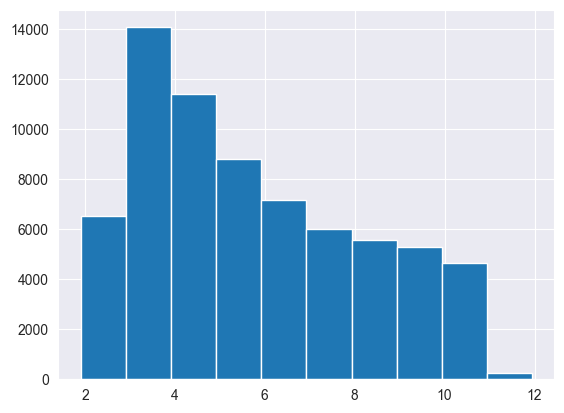

In [9]:
duration_df = pd.DataFrame({"file":files, "samples":samples, "dur":durations}).set_index('file')
train_data = train_data.join(duration_df)
valid_data = valid_data.join(duration_df)
duration_df.dur.hist();

In [10]:
bins=20

train_data['bin'] = pd.cut(train_data.dur, bins=bins, labels=range(bins))
train_data.loc[train_data['bin']==19, 'bin'] = 18 # merge last bin due to only one record

valid_data['bin'] = pd.cut(valid_data.dur, bins=bins, labels=range(bins))

In [11]:
weight = len(train_data[train_data['is_active'] == 0])/len(train_data[train_data['is_active'] == 1])

# Precompute w2v features

W2v convolutional encoder consumes a lot of GPU. To avoid it during training, the features are precomputed.

In [12]:
audios_mean,audios_sdt = (-0.00011539726044066538, 0.07812332811748154)
raw_audio_datasets_train = create_binned_datasets(train_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))
raw_audio_datasets_valid = create_binned_datasets(valid_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))

w2v_feature_extractor = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").feature_extractor


C:\Users\Nazrin\PycharmProjects\detecting_active_emotion\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print(len(raw_audio_datasets_train))
print(len(raw_audio_datasets_valid))

for ds in chain(raw_audio_datasets_train, raw_audio_datasets_valid):
  extract_w2v_features(ds, w2v_feature_extractor, w2v_features_path, bs=32, device=device)

The syntax of the command is incorrect.


19
20


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


# Spectrograms fixed length dataset

In [14]:
window = 640 # 40ms
hop = 320 # 20 ms
mels=64
maxl = max(get_max_spectrogram_length(train_data,hop), get_max_spectrogram_length(valid_data,hop))
print(f'maxl {maxl}')
spctr_norms = (-5.612719667630828, 12.146062730351977)

maxl 598


In [15]:
spctr_dataset_train_fixed = create_spectrogram_ds(train_data, maxl=maxl,norms=spctr_norms,w=window,hop=hop,n_mels=mels)
spctr_dataset_valid_fixed = create_spectrogram_ds(valid_data, maxl = maxl,norms=spctr_norms,w=window,n_mels=mels)

# |Spectrograms binned datasets

In [16]:
window = 640 # 40ms
hop = 320 # 20 ms
mels= 64
spctr_binned_dataset_norms = (-10.58189139511126, 14.482822057824656)
spctr_dataset_builder = partial(create_spectrogram_ds,norms=spctr_binned_dataset_norms,w=window,hop=hop,n_mels=mels)
spctr_ds_train_binned = create_binned_datasets(train_data, spctr_dataset_builder)
spctr_ds_valid_binned = create_binned_datasets(valid_data, spctr_dataset_builder)

# W2V datasets binned

In [17]:
w2v2_datasets_train = create_binned_datasets(train_data, partial(create_file_ds, path=w2v_features_path))
w2v2_datasets_valid = create_binned_datasets(valid_data, partial(create_file_ds, path=w2v_features_path))

# Hybrid

In [18]:
from data.utils import create_hybrid_datasets_binned
from data.dataloader import collate_hybrid

In [19]:
hybrid_datasets_train = create_hybrid_datasets_binned(w2v2_datasets_train, spctr_ds_train_binned)
hybrid_datasets_valid = create_hybrid_datasets_binned(w2v2_datasets_valid, spctr_ds_valid_binned)

In [20]:
hybrid_dl_train = MultiDataLoader(hybrid_datasets_train, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))
hybrid_dl_valid = MultiDataLoader(hybrid_datasets_valid, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))

In [21]:
for ds in chain(hybrid_datasets_train,hybrid_datasets_valid):
  ds.prefetch(1)

100%|██████████| 506/506 [00:10<00:00, 47.58it/s]


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1774/1774 [08:43<00:00,  3.39it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.843917,0.818253,0.762707,0.602368,0.719579,0.517992


100%|██████████| 1774/1774 [08:44<00:00,  3.39it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.815698,0.832749,0.768353,0.600786,0.753782,0.499419


100%|██████████| 1774/1774 [08:44<00:00,  3.38it/s]


,train_loss,test_loss,auc,f1,recall,precision
2,0.805907,0.807901,0.771864,0.607982,0.706424,0.53362


100%|██████████| 1774/1774 [08:43<00:00,  3.39it/s]


,train_loss,test_loss,auc,f1,recall,precision
3,0.799025,0.798692,0.773586,0.608934,0.682964,0.549383


100%|██████████| 1774/1774 [08:44<00:00,  3.38it/s]


,train_loss,test_loss,auc,f1,recall,precision
4,0.793632,0.79852,0.775972,0.611793,0.726814,0.528203


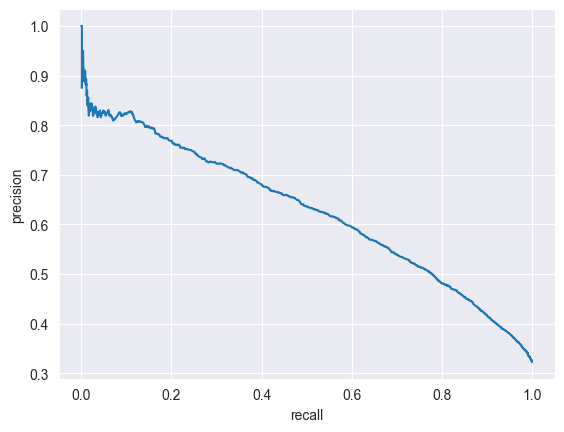

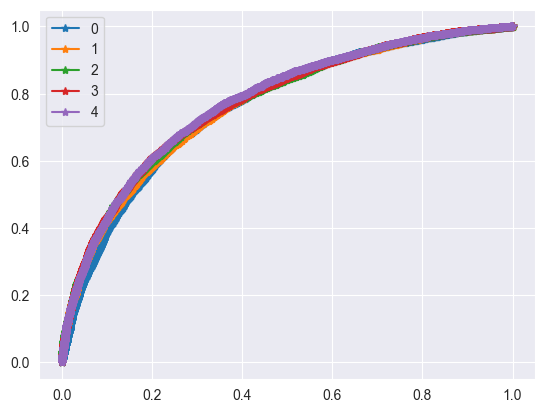

100%|██████████| 1774/1774 [09:24<00:00,  3.14it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,0.766547,0.729342,0.821094,0.657362,0.712563,0.610099


100%|██████████| 1774/1774 [09:26<00:00,  3.13it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,0.708775,0.728801,0.821721,0.655883,0.715633,0.605341


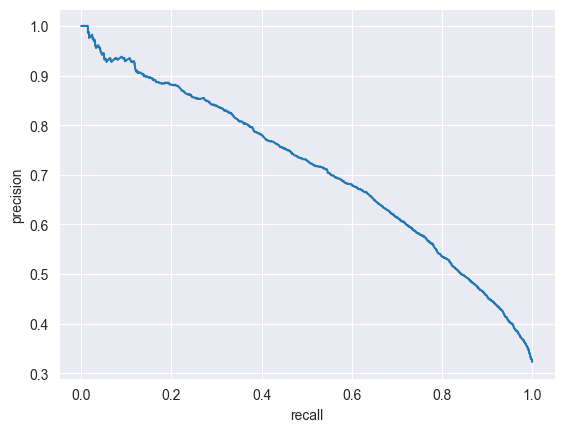

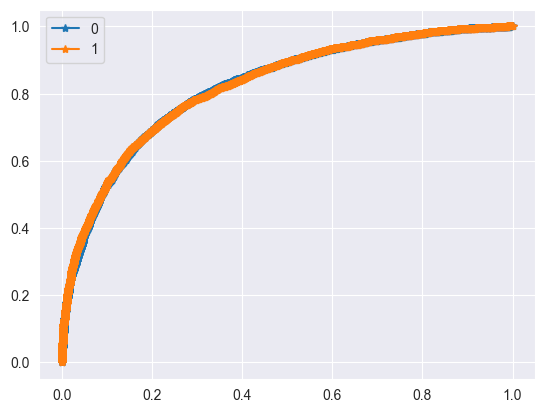

In [22]:
from experiments.models import HybridModel, ConvNextModel, AttentionFusion

spctr_model = ConvNextModel(name = 'convnext_tiny')
attention_fusion = AttentionFusion()
model = HybridModel(spctr_model=spctr_model, fusion=attention_fusion)

hybrid_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = hybrid_dl_train,
    valid_dl = hybrid_dl_valid,
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 5,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True,
    gradient_accumulation_size = 64
)

training = Training(hybrid_training_config)

training.run()

In [23]:
errors_report = training.trainer.cbs.callbacks[-3].get_eval_report()
errors_report.to_csv('errors_report.csv')

In [24]:
import torch

torch.save(model.w2v2, "hybrid_w2v_model.pth")
torch.save(model.w2v2.state_dict(), "hybrid_w2v_model_state_dict.pth")
torch.save(model.spctr_model, "hybrid_spctr_model.pth")
torch.save(model.spctr_model.state_dict(), "hybrid_spctr_model_state_dict.pth")
torch.save(model.head, "hybrid_head.pth")
torch.save(model.head.state_dict(), "hybrid_head_state_dict.pth")

# W2V

In [ ]:
w2v2dl_train = MultiDataLoader(w2v2_datasets_train, partial(create_dataloader, bs=16))
w2v2dl_valid = MultiDataLoader(w2v2_datasets_valid, partial(create_dataloader, bs=16))

w2v_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = W2V2Model(),
    train_dl = w2v2dl_train,
    valid_dl = w2v2dl_valid,
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 1,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True,
    gradient_accumulation_size = 64
)

training = Training(w2v_training_config)

training.run()

# ViT

In [ ]:
spctr_dataset_train_fixed.prefetch(0.6)
spctr_dataset_valid_fixed.prefetch(0.6)

In [ ]:
from experiments.models import ViTModel

model = ViTModel(im_size=(mels, maxl),
                 name = 'deit_tiny_distilled_patch16_224',
                 dropout=0.3)

vit_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = create_dataloader(spctr_dataset_train_fixed, bs=64),
    valid_dl = create_dataloader(spctr_dataset_valid_fixed, bs=64),
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 1,
    learning_rate = 1e-2,
    head_pretrain_learning_rate = 1e-2,
    mixed_precision = True
)

training = Training(vit_training_config)

training.run()

In [ ]:
import torch

torch.save(model.model, "vit_model.pth")
torch.save(model.model.state_dict(), "vit_model_state_dict.pth")

# Pretrained CNN

In [ ]:
for ds in chain(spctr_ds_train_binned,spctr_ds_valid_binned):
  ds.prefetch(1)

In [ ]:
model = ConvNextModel(name = 'convnext_tiny', dropout=0.2)

training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = MultiDataLoader(spctr_ds_train_binned, partial(create_dataloader, bs=64)),
    valid_dl = MultiDataLoader(spctr_ds_valid_binned, partial(create_dataloader, bs=64)),
    optimizer = torch.optim.AdamW,
    weight_decay = 4,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 3,
    learning_rate = 1e-4/2,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True
)

training = Training(training_config)

training.run()

# Custom CNN Transformer

In [ ]:
from experiments.models import CustomConvTransformer

In [ ]:
for ds in chain(spctr_ds_train_binned,spctr_ds_valid_binned):
  ds.prefetch(1)

In [ ]:
from experiments.models import convolution_block, ResidualBlock

cnn = nn.Sequential(
        convolution_block(1,32),
        nn.MaxPool2d(2),
        ResidualBlock(32, 32),
        nn.MaxPool2d(2),
        ResidualBlock(32, 64),
        nn.MaxPool2d(2),
        ResidualBlock(64, 64),
        nn.MaxPool2d(2),
        ResidualBlock(64, 128),
        nn.MaxPool2d(2)
    )



training_config = TrainingConfig(
    fine_tune = False,
    device = device,
    model = CustomConvTransformer(cnn,conv_emb_dim=128,target_dim=256,layers=3),
    train_dl = MultiDataLoader(spctr_ds_train_binned, partial(create_dataloader, bs=64)),
    valid_dl = MultiDataLoader(spctr_ds_valid_binned, partial(create_dataloader, bs=64)),
    optimizer = torch.optim.AdamW,
    weight_decay = 3,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 5,
    learning_rate = 1e-4/2,
    mixed_precision = True
)

training = Training(training_config)

training.run()

# Errors analysis

In [30]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [31]:
errors_report =  pd.read_csv('errors_report.csv', index_col=0)
errors_report['errors'] = -np.log(np.where(errors_report.targ==1, errors_report.pred, 1-errors_report.pred))
errors_report = errors_report.set_index('id')

In [32]:
report = errors_report.join(valid_data)

C:\Users\Nazrin\AppData\Local\Temp\ipykernel_8224\2214504395.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r1 = r1.groupby('dur').apply(lambda x: pd.Series({"cnt":len(x), "mean_loss":x['errors'].mean()}))


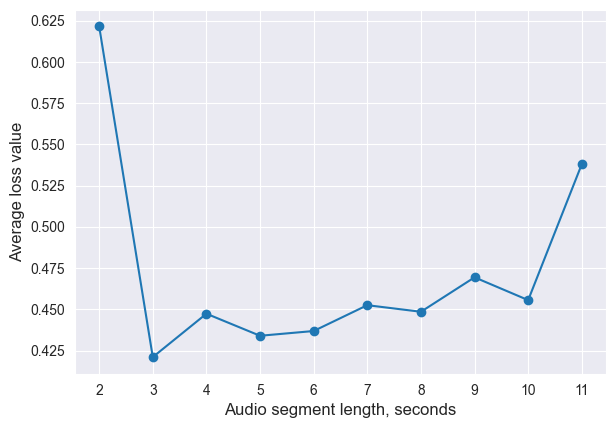

In [33]:
r1 = report.copy()
r1.dur = round(r1.dur).astype(int)
r1 = r1.groupby('dur').apply(lambda x: pd.Series({"cnt":len(x), "mean_loss":x['errors'].mean()}))
#_,ax = plt.subplots(1)
cm = 1/2.54  # centimeters in inches
_,ax = plt.subplots(figsize=(17.4*cm, 12*cm))
ax = r1['mean_loss'].plot(marker='o', ax=ax)
plt.ylabel('Average loss value',fontsize=12)
plt.xlabel('Audio segment length, seconds',fontsize=12)
ax.set_xticks([2,3,4,5,6,7,8,9,10,11])
plt.savefig(fname='lenloss', dpi=600)
#r1.cnt.plot.bar(rot=0,ax=ax[1])


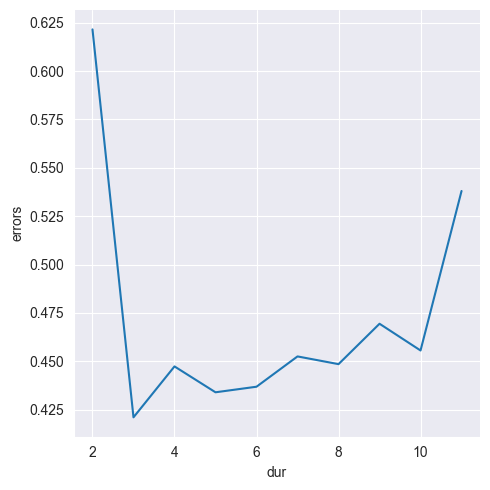

In [34]:
sns.relplot(data=report, x=round(report.dur), y='errors', kind="line", errorbar=None)

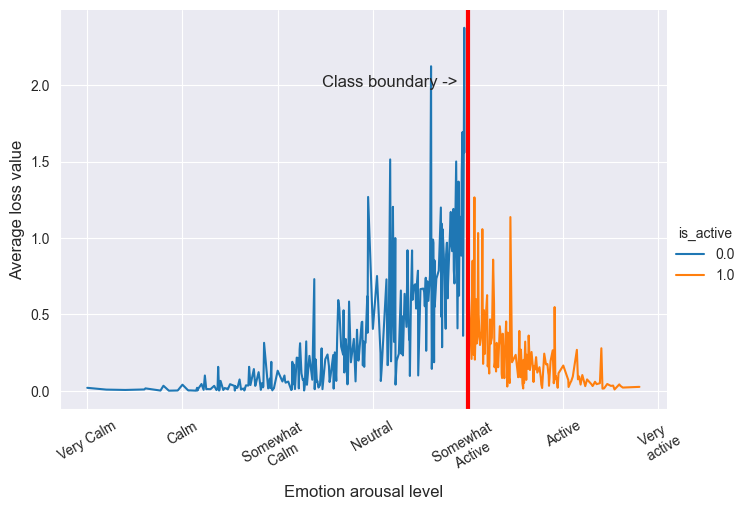

In [35]:
import seaborn as sns

cm = 1/2.54
sns.relplot(data=report, x="EmoAct", y="errors", kind="line", hue='is_active', errorbar=None,
            height=12*cm, aspect=(17.4/12))
ax = plt.gca()
ax.axvline(x=5, color='r', linewidth=3)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['Very Calm', 'Calm', 'Somewhat \n Calm', 'Neutral', 'Somewhat \n Active', 'Active', 'Very \n active'], rotation=30);
plt.xlabel('Emotion arousal level',fontsize=12)
plt.ylabel('Average loss value', fontsize=12)
plt.annotate("Class boundary ->", (4.18, 1.9),
                 xycoords="data",
                 textcoords="offset points",
                 xytext=(0, 10), ha="center", fontsize=12)
plt.savefig(fname='actloss2', dpi=600,bbox_inches='tight')


<Axes: xlabel='EmoAct', ylabel='errors'>

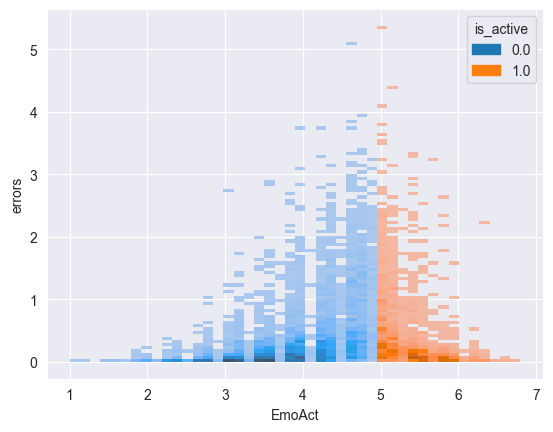

In [36]:
sns.histplot(data=report, x="EmoAct", y="errors", hue='is_active')

C:\Users\Nazrin\AppData\Local\Temp\ipykernel_8224\1612871793.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report[report['errors'] > 0.6].groupby('EmoClass').apply(lambda x: x['errors'].mean()).plot.bar()


<Axes: xlabel='EmoClass'>

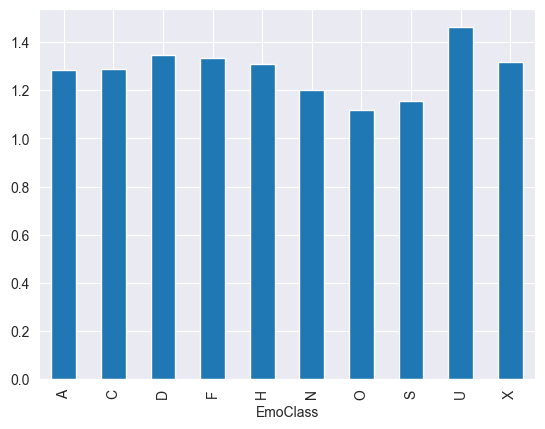

In [38]:
report[report['errors'] > 0.6].groupby('EmoClass').apply(lambda x: x['errors'].mean()).plot.bar()